<a href="https://colab.research.google.com/github/eisbetterthanpi/pytorch/blob/main/reinforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### setup

In [ ]:
# https://huggingface.co/blog/deep-rl-pg
# https://colab.research.google.com/github/huggingface/deep-rl-class/blob/main/unit5/unit5.ipynb
# Reinforce (aka Monte Carlo Policy Gradient) Policy-Gradient Method
!apt install python-opengl ffmpeg xvfb
!pip3 install pyvirtualdisplay
# Virtual display
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(500, 500))
virtual_display.start()

!pip install gym
!pip install git+https://github.com/ntasfi/PyGame-Learning-Environment.git
!pip install git+https://github.com/qlan3/gym-games.git # Extra gym environments made with PyGame
# !pip install huggingface_hub
# https://huggingface.co/models?other=reinforce

!pip install pyyaml==6.0 # avoid key error metadata
!pip install pyglet # Virtual Screen

import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import gym
import gym_pygame
# from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.
import imageio # To generate a replay video

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!pip install colabgymrender


#### policy

In [ ]:
# https://github.com/pytorch/examples/blob/main/reinforcement_learning/reinforce.py
# https://github.com/udacity/deep-reinforcement-learning/blob/master/reinforce/REINFORCE.ipynb
# https://github.com/lbarazza/VPG-PyTorch/blob/master/vpg.py

# class Policy(nn.Module):
#     def __init__(self, s_size, a_size, h_size):
#         super(Policy, self).__init__()
#         self.model=nn.Sequential(
#             nn.Linear(s_size, h_size), nn.ReLU(),
#             nn.Linear(h_size, a_size),
#             # nn.Linear(h_size, h_size*2), nn.ReLU(),
#             # nn.Linear(h_size*2, a_size),
#             nn.Softmax(dim=1),
#         )
    
#     def forward(self, state): # og discrete
#         state = torch.from_numpy(state).float().unsqueeze(0).to(device)
#         probs = self.model(state).cpu()
#         m = Categorical(probs)
#         action = m.sample() # can't use action = np.argmax(m) use  m.sample(), sample an action with prob dist P(.|s)
#         return action.item(), m.log_prob(action)


# https://github.com/NadeemWard/pytorch_simple_policy_gradients/blob/master/reinforce/REINFORCE_continuous.py

class Policy(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size):
        super(Policy, self).__init__()
        self.model=nn.Sequential(
            nn.Linear(num_inputs, hidden_size), nn.ReLU(),
        )
        self.mean = nn.Linear(hidden_size, num_outputs)
        self.log_std = nn.Linear(hidden_size, num_outputs)

    def forward(self, state): # continuous
        # state = torch.from_numpy(state).float().unsqueeze(0)
        x = self.model(state)
        mean = self.mean(x)
        log_std = self.log_std(x) # if more than one action this will give you the diagonal elements of a diagonal covariance matrix
        log_std = torch.clamp(log_std, min=-20, max=2) # We limit the variance by forcing within a range of -2,20
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        action = normal.sample()
        ln_prob = normal.log_prob(action)
        ln_prob = ln_prob.sum()
        ln_prob=ln_prob.view(1,-1)
        # print("ln_prob",ln_prob)
        action = torch.tanh(action)
        action = action.cpu().numpy()
        # action=np.array([action])
        # print(action) #numpy.float32
        return action, ln_prob #, mean, std


#### reinforce

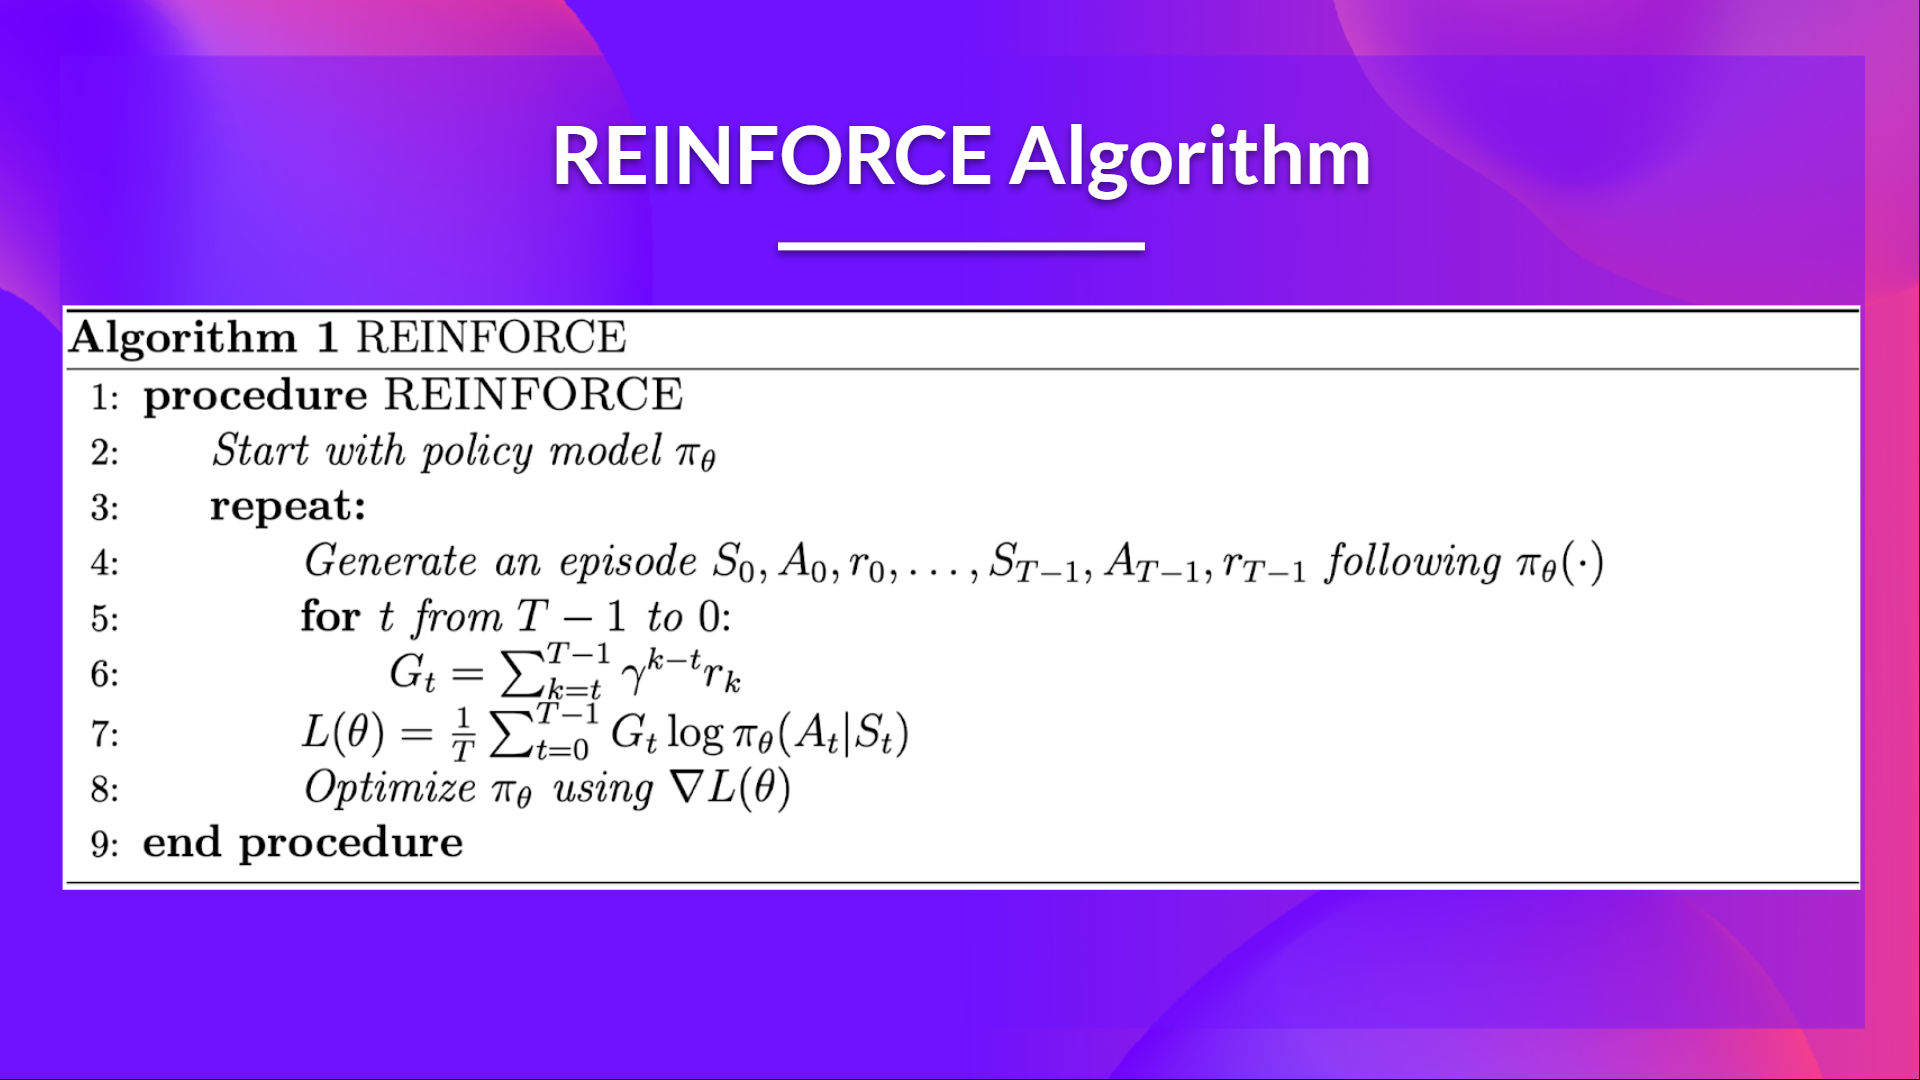

In [ ]:

# update policy after every episode
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Line 4 of pseudocode run 1 full episode using current policy
        for t in range(max_t):
            state = torch.tensor(state.copy()).type(torch.float).to(device) # i added, change from int to float
            action, log_prob = policy(state)
            # print("action, log_prob",action, log_prob)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        # Line 6 of pseudocode: calculate the return
        discounts = [gamma**i for i in range(len(rewards)+1)] # [0.99^1, 0.99^2, 0.99^3, ..., 0.99^len(rewards)]
        ## We calculate the return by sum(gamma[t] * reward[t]) 
        # R = sum([a*b for a,b in zip(discounts, rewards)])
        R = sum([a*b for a,b in zip(discounts, rewards)]) - np.mean(scores_deque) # baseline subtraction from discord
        # R = sum([gamma**a*b for a,b in enumerate(rewards)])
        # R=torch.tensor(R) #c
        # print("R",R)
        # Line 7:
        policy_loss = []
        for log_prob in saved_log_probs:
            # print("log_prob * R",log_prob , R)
            # print(log_prob.shape , R.shape)
            # print((log_prob*R).shape)
            policy_loss.append(-log_prob * R)
        # print("policy_loss",policy_loss)
        policy_loss = torch.cat(policy_loss).sum()
        # max πθ(a3|s;θ) = min 1−πθ(a3|s;θ)
       
        optimizer.zero_grad() # Line 8: loss.backward()
        policy_loss.backward()
        optimizer.step()
        if i_episode % 100 == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
    return scores


#### wwwwwwwwwwwwwwww

In [ ]:
# env_id = "CartPole-v1"
# episode ends if: The pole Angle is greater than ±12°; Cart Position is greater than ±2.4; Episode length is greater than 500
# reward of +1 every timestep

# env_id = "Pixelcopter-PLE-v0"
# observation space (7): player y position, velocity, distance to floor/ceiling; next block x distance to player; next blocks top/bottom y location
# action space(2): Up/Down
# reward function: vertical block passed +1, terminal state reached -1

# env_id = "Pong-PLE-v0"
# observation space (7): player y position, velocity; cpu y position; ball x/y position, x/y velocity
# action space(3): Paddle Up/ Down/No movement
# reward function: +1 win, -1 lose

# continuous
env_id = "Pendulum-v0"

env = gym.make(env_id)
eval_env = gym.make(env_id)
s_size = env.observation_space.shape[0]
# a_size = env.action_space.n
# a_size = env.action_space
a_size = 1
# print(env.action_space)



h_size=16 # cp 16 pc 64 p 64
n_training_episodes=1000 # cp 1000 pc 50000 p 20000
n_evaluation_episodes=10
max_t=1000 # cp 1000 pc 10000 p 5000 max episode length
gamma=0.99 # cp 1.0 pc/p 0.99
lr=1e-4  # cp 1e-2 pc 1e-4 p 1e-2
env_id=env_id
state_space=s_size
action_space=a_size

policy = Policy(state_space, action_space, h_size).to(device)
optimizer = optim.Adam(policy.parameters(), lr=lr)


#### Train

In [ ]:

scores = reinforce(policy, optimizer, n_training_episodes, max_t, gamma)


#### eval

In [ ]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
    episode_rewards = []
    for episode in range(n_eval_episodes):
        state = env.reset()
        step = 0
        done = False
        total_rewards_ep = 0
        for step in range(max_steps):
            action, _ = policy(state)
            new_state, reward, done, info = env.step(action)
            total_rewards_ep += reward
            if done:
                break
            state = new_state
            episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    return mean_reward, std_reward

evaluate_agent(eval_env, max_t, n_evaluation_episodes, policy)


#### save

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')
PATH="/content/gdrive/MyDrive/curious/" # for saving to google drive
name='Curious_reinforce_cp.pth'
# PATH="/content/" # for saving on colab only
# name='model.pth'

model=policy
# torch.save(model.state_dict(), PATH+name)

# model.load_state_dict(torch.load(PATH+name))
# actor=model


#### video

In [ ]:
!pip install imageio-ffmpeg

In [ ]:
# make mp4
def record_video(env, policy, out_directory, fps=30):
    images = []  
    done = False
    state = env.reset()
    img = env.render(mode='rgb_array')
    images.append(img)
    while not done:
        # Take the action (index) that have the maximum expected future reward given that state
        state = torch.tensor(state.copy()).type(torch.float).to(device) # i added, change from int to float
        action, _ = policy(state)
        state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
        img = env.render(mode='rgb_array')
        images.append(img)
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)
record_video(env, policy, "video.mp4")


In [ ]:

from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:

import gym
from colabgymrender.recorder import Recorder
# from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT

# "MontezumaRevengeDeterministic-v4"
env = gym.make(env_id)
# env = SparseEnv(env)
# env = gym_super_mario_bros.make('SuperMarioBros-v0')
# env = JoypadSpace(env, COMPLEX_MOVEMENT) # SIMPLE_MOVEMENT COMPLEX_MOVEMENT
# env = MarioSparse(env)
# env = MarioEarlyStop(env)
env = Recorder(env, './video')

state = env.reset()
# model.eval()
x=0

while True:
    # # print("action",action)
    # # action = env.action_space.sample()
    x+=1
    action, _ = policy(state)
    state, reward, done, info = env.step(action)
    if done: break
env.play()
print(x)

